In [70]:
import BoolODE as bo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
from Perturbation import perturbation as pt
%autoreload 1 # not working

In [99]:
# user setting
model_definition = "dyn-cycle.txt"

# perturbation parameter validation
# either of perturbation_transcription and perturbation_translation should be []
# either of perturbation_transcription and perturbation_translation should be float or list of dict
perturbed_transcription = 0.5 #[] #[{ 'g1': 10.0 }, { 'g2': 10.0 }]
perturbed_translation = [] #[{ 'Gata2': 0.5 }, { 'Cebpa': 0.3 }] # [{ 'g3': 5.0 }, { 'g4': 5.0 }] # 0.5

simulation_time = 30 # * 100 step
num_cells = 10 # = # of sampling_cells
sampling_time = [100, 300, 500] # 1~simulation_time*100-1?
output_dir = "Run1945" # change every simulation
output_filename = "PerturbationSampling.npy" # npy file
modeltype = "hill" # or heaviside

# default
do_parallel = False
sample_cells = False

In [100]:
# execution from module

# output: 
# E -> {output_dir}/{output_filename}
# grn_mtx -> {output_dir}/GRN_mtx_columns_regulate_rows.csv
# normal simulationの結果 -> {output_dir}/{model_definition}/
# perturbation controlの結果 -> {output_dir}/{model_definition}-perturbation-control/
# 各perturbationの結果 -> {output_dir}/{model_definition}-perturbation-{perturbされたgene}/

E, gene_names, grn_mtx = pt.perturbation(
    model_definition, 
    simulation_time,
    num_cells,
    sampling_time,
    perturbed_transcription, 
    perturbed_translation,
    output_dir,
    output_filename,
    modeltype
)

  0%|          | 0/10 [00:00<?, ?it/s]

Creating output folders
Run1945/dyn-cycle does not exist, creating it...
Starting simulations
Fixing rate parameters to defaults
{'n_g1': 10.0, 'n_g2': 10.0, 'n_g3': 10.0, 'n_g4': 10.0, 'n_g5': 10.0, 'n_g6': 10.0, 'k_g1': 10.0, 'k_g2': 10.0, 'k_g3': 10.0, 'k_g4': 10.0, 'k_g5': 10.0, 'k_g6': 10.0, 'sigmaH_g1': 10.0, 'sigmaH_g2': 10.0, 'sigmaH_g3': 10.0, 'sigmaH_g4': 10.0, 'sigmaH_g5': 10.0, 'sigmaH_g6': 10.0, 'm_g1': 20.0, 'm_g2': 20.0, 'm_g3': 20.0, 'm_g4': 20.0, 'm_g5': 20.0, 'm_g6': 20.0, 'l_x_g1': 10.0, 'l_x_g2': 10.0, 'l_x_g3': 10.0, 'l_x_g4': 10.0, 'l_x_g5': 10.0, 'l_x_g6': 10.0, 'r_g1': 10.0, 'r_g2': 10.0, 'r_g3': 10.0, 'r_g4': 10.0, 'r_g5': 10.0, 'r_g6': 10.0, 'l_p_g1': 1.0, 'l_p_g2': 1.0, 'l_p_g3': 1.0, 'l_p_g4': 1.0, 'l_p_g5': 1.0, 'l_p_g6': 1.0}
Run1945/dyn-cycle/simulations does not exist, creating it...
Starting simulations


 10%|█         | 1/10 [00:00<00:00,  9.05it/s]

Simulations took 5.173 s


  0%|          | 0/10 [00:00<?, ?it/s]

Concating files took 1.15 s
Requested nClusters=1, not performing k-means clustering
Generating input files for pipline...
1. refNetwork
2. PseudoTime.csv
Dataset too large.
Sampling 10 cells, one from each simulated trajectory.
Input file generation took 0.16 s
BoolODE.py took 6.50s

 
 

Normal simulation ... Done
Starting perturbation control simulation...
Creating output folders
Run1945/dyn-cycle-perturbation-control does not exist, creating it...
Starting simulations
Fixing rate parameters to defaults
{'n_g1': 10.0, 'n_g2': 10.0, 'n_g3': 10.0, 'n_g4': 10.0, 'n_g5': 10.0, 'n_g6': 10.0, 'k_g1': 10.0, 'k_g2': 10.0, 'k_g3': 10.0, 'k_g4': 10.0, 'k_g5': 10.0, 'k_g6': 10.0, 'sigmaH_g1': 10.0, 'sigmaH_g2': 10.0, 'sigmaH_g3': 10.0, 'sigmaH_g4': 10.0, 'sigmaH_g5': 10.0, 'sigmaH_g6': 10.0, 'm_g1': 20.0, 'm_g2': 20.0, 'm_g3': 20.0, 'm_g4': 20.0, 'm_g5': 20.0, 'm_g6': 20.0, 'l_x_g1': 10.0, 'l_x_g2': 10.0, 'l_x_g3': 10.0, 'l_x_g4': 10.0, 'l_x_g5': 10.0, 'l_x_g6': 10.0, 'r_g1': 10.0, 'r_g2': 10.

 10%|█         | 1/10 [00:00<00:01,  6.78it/s]

Simulations took 7.272 s


100%|██████████| 10/10 [00:01<00:00,  7.69it/s]


Concating files took 1.31 s
Requested nClusters=1, not performing k-means clustering
Generating input files for pipline...
1. refNetwork
2. PseudoTime.csv
Dataset too large.
Sampling 10 cells, one from each simulated trajectory.
Perturbation output ...
Input file generation took 0.19 s
BoolODE.py took 8.79s
Starting perturbation simulation...

 
 

Starting transcription perturbation simulation...


---------
g1 perturbation
---------
Creating output folders
Run1945/dyn-cycle-perturbation-transcription-g1 does not exist, creating it...
Starting simulations
Fixing rate parameters to defaults
Setting trancsription perturbation parameters...
{'n_g1': 10.0, 'n_g2': 10.0, 'n_g3': 10.0, 'n_g4': 10.0, 'n_g5': 10.0, 'n_g6': 10.0, 'k_g1': 10.0, 'k_g2': 10.0, 'k_g3': 10.0, 'k_g4': 10.0, 'k_g5': 10.0, 'k_g6': 10.0, 'sigmaH_g1': 10.0, 'sigmaH_g2': 10.0, 'sigmaH_g3': 10.0, 'sigmaH_g4': 10.0, 'sigmaH_g5': 10.0, 'sigmaH_g6': 10.0, 'm_g1': 10.0, 'm_g2': 20.0, 'm_g3': 20.0, 'm_g4': 20.0, 'm_g5': 20.0, 

  0%|          | 0/10 [00:00<?, ?it/s]

Run1945/dyn-cycle-perturbation-transcription-g1/simulations does not exist, creating it...
Starting simulations


 10%|█         | 1/10 [00:00<00:01,  8.17it/s]

Simulations took 6.965 s


  0%|          | 0/10 [00:00<?, ?it/s]

Concating files took 1.03 s
Requested nClusters=1, not performing k-means clustering
Generating input files for pipline...
1. refNetwork
2. PseudoTime.csv
Dataset too large.
Sampling 10 cells, one from each simulated trajectory.
Perturbation output ...
Input file generation took 0.16 s
BoolODE.py took 8.18s


---------
g2 perturbation
---------
Creating output folders
Run1945/dyn-cycle-perturbation-transcription-g2 does not exist, creating it...
Starting simulations
Fixing rate parameters to defaults
Setting trancsription perturbation parameters...
{'n_g1': 10.0, 'n_g2': 10.0, 'n_g3': 10.0, 'n_g4': 10.0, 'n_g5': 10.0, 'n_g6': 10.0, 'k_g1': 10.0, 'k_g2': 10.0, 'k_g3': 10.0, 'k_g4': 10.0, 'k_g5': 10.0, 'k_g6': 10.0, 'sigmaH_g1': 10.0, 'sigmaH_g2': 10.0, 'sigmaH_g3': 10.0, 'sigmaH_g4': 10.0, 'sigmaH_g5': 10.0, 'sigmaH_g6': 10.0, 'm_g1': 20.0, 'm_g2': 10.0, 'm_g3': 20.0, 'm_g4': 20.0, 'm_g5': 20.0, 'm_g6': 20.0, 'l_x_g1': 10.0, 'l_x_g2': 10.0, 'l_x_g3': 10.0, 'l_x_g4': 10.0, 'l_x_g5': 10.0

 10%|█         | 1/10 [00:00<00:01,  8.94it/s]

Simulations took 6.893 s


  0%|          | 0/10 [00:00<?, ?it/s]

Concating files took 1.11 s
Requested nClusters=1, not performing k-means clustering
Generating input files for pipline...
1. refNetwork
2. PseudoTime.csv
Dataset too large.
Sampling 10 cells, one from each simulated trajectory.
Perturbation output ...
Input file generation took 0.17 s
BoolODE.py took 8.20s


---------
g3 perturbation
---------
Creating output folders
Run1945/dyn-cycle-perturbation-transcription-g3 does not exist, creating it...
Starting simulations
Fixing rate parameters to defaults
Setting trancsription perturbation parameters...
{'n_g1': 10.0, 'n_g2': 10.0, 'n_g3': 10.0, 'n_g4': 10.0, 'n_g5': 10.0, 'n_g6': 10.0, 'k_g1': 10.0, 'k_g2': 10.0, 'k_g3': 10.0, 'k_g4': 10.0, 'k_g5': 10.0, 'k_g6': 10.0, 'sigmaH_g1': 10.0, 'sigmaH_g2': 10.0, 'sigmaH_g3': 10.0, 'sigmaH_g4': 10.0, 'sigmaH_g5': 10.0, 'sigmaH_g6': 10.0, 'm_g1': 20.0, 'm_g2': 20.0, 'm_g3': 10.0, 'm_g4': 20.0, 'm_g5': 20.0, 'm_g6': 20.0, 'l_x_g1': 10.0, 'l_x_g2': 10.0, 'l_x_g3': 10.0, 'l_x_g4': 10.0, 'l_x_g5': 10.0

 10%|█         | 1/10 [00:00<00:00,  9.48it/s]

Simulations took 6.842 s


  0%|          | 0/10 [00:00<?, ?it/s]

Concating files took 1.04 s
Requested nClusters=1, not performing k-means clustering
Generating input files for pipline...
1. refNetwork
2. PseudoTime.csv
Dataset too large.
Sampling 10 cells, one from each simulated trajectory.
Perturbation output ...
Input file generation took 0.17 s
BoolODE.py took 8.07s


---------
g4 perturbation
---------
Creating output folders
Run1945/dyn-cycle-perturbation-transcription-g4 does not exist, creating it...
Starting simulations
Fixing rate parameters to defaults
Setting trancsription perturbation parameters...
{'n_g1': 10.0, 'n_g2': 10.0, 'n_g3': 10.0, 'n_g4': 10.0, 'n_g5': 10.0, 'n_g6': 10.0, 'k_g1': 10.0, 'k_g2': 10.0, 'k_g3': 10.0, 'k_g4': 10.0, 'k_g5': 10.0, 'k_g6': 10.0, 'sigmaH_g1': 10.0, 'sigmaH_g2': 10.0, 'sigmaH_g3': 10.0, 'sigmaH_g4': 10.0, 'sigmaH_g5': 10.0, 'sigmaH_g6': 10.0, 'm_g1': 20.0, 'm_g2': 20.0, 'm_g3': 20.0, 'm_g4': 10.0, 'm_g5': 20.0, 'm_g6': 20.0, 'l_x_g1': 10.0, 'l_x_g2': 10.0, 'l_x_g3': 10.0, 'l_x_g4': 10.0, 'l_x_g5': 10.0

 20%|██        | 2/10 [00:00<00:00, 10.79it/s]

Simulations took 6.409 s


100%|██████████| 10/10 [00:01<00:00,  9.85it/s]


Concating files took 1.02 s
Requested nClusters=1, not performing k-means clustering
Generating input files for pipline...
1. refNetwork
2. PseudoTime.csv
Dataset too large.
Sampling 10 cells, one from each simulated trajectory.
Perturbation output ...
Input file generation took 0.19 s
BoolODE.py took 7.63s


---------
g5 perturbation
---------
Creating output folders
Run1945/dyn-cycle-perturbation-transcription-g5 does not exist, creating it...
Starting simulations
Fixing rate parameters to defaults
Setting trancsription perturbation parameters...
{'n_g1': 10.0, 'n_g2': 10.0, 'n_g3': 10.0, 'n_g4': 10.0, 'n_g5': 10.0, 'n_g6': 10.0, 'k_g1': 10.0, 'k_g2': 10.0, 'k_g3': 10.0, 'k_g4': 10.0, 'k_g5': 10.0, 'k_g6': 10.0, 'sigmaH_g1': 10.0, 'sigmaH_g2': 10.0, 'sigmaH_g3': 10.0, 'sigmaH_g4': 10.0, 'sigmaH_g5': 10.0, 'sigmaH_g6': 10.0, 'm_g1': 20.0, 'm_g2': 20.0, 'm_g3': 20.0, 'm_g4': 20.0, 'm_g5': 10.0, 'm_g6': 20.0, 'l_x_g1': 10.0, 'l_x_g2': 10.0, 'l_x_g3': 10.0, 'l_x_g4': 10.0, 'l_x_g5': 10.0

  0%|          | 0/10 [00:00<?, ?it/s]

Run1945/dyn-cycle-perturbation-transcription-g5/simulations does not exist, creating it...
Starting simulations


 20%|██        | 2/10 [00:00<00:00, 10.61it/s]

Simulations took 6.786 s


  0%|          | 0/10 [00:00<?, ?it/s]

Concating files took 1.00 s
Requested nClusters=1, not performing k-means clustering
Generating input files for pipline...
1. refNetwork
2. PseudoTime.csv
Dataset too large.
Sampling 10 cells, one from each simulated trajectory.
Perturbation output ...
Input file generation took 0.17 s
BoolODE.py took 7.98s


---------
g6 perturbation
---------
Creating output folders
Run1945/dyn-cycle-perturbation-transcription-g6 does not exist, creating it...
Starting simulations
Fixing rate parameters to defaults
Setting trancsription perturbation parameters...
{'n_g1': 10.0, 'n_g2': 10.0, 'n_g3': 10.0, 'n_g4': 10.0, 'n_g5': 10.0, 'n_g6': 10.0, 'k_g1': 10.0, 'k_g2': 10.0, 'k_g3': 10.0, 'k_g4': 10.0, 'k_g5': 10.0, 'k_g6': 10.0, 'sigmaH_g1': 10.0, 'sigmaH_g2': 10.0, 'sigmaH_g3': 10.0, 'sigmaH_g4': 10.0, 'sigmaH_g5': 10.0, 'sigmaH_g6': 10.0, 'm_g1': 20.0, 'm_g2': 20.0, 'm_g3': 20.0, 'm_g4': 20.0, 'm_g5': 20.0, 'm_g6': 10.0, 'l_x_g1': 10.0, 'l_x_g2': 10.0, 'l_x_g3': 10.0, 'l_x_g4': 10.0, 'l_x_g5': 10.0

 20%|██        | 2/10 [00:00<00:00, 11.29it/s]

Simulations took 6.939 s


100%|██████████| 10/10 [00:00<00:00, 10.35it/s]


Concating files took 0.97 s
Requested nClusters=1, not performing k-means clustering
Generating input files for pipline...
1. refNetwork
2. PseudoTime.csv
Dataset too large.
Sampling 10 cells, one from each simulated trajectory.
Perturbation output ...
Input file generation took 0.18 s
BoolODE.py took 8.11s

 
 
 
Writing GRN matrix to csv file...
It's all Done!!


In [101]:
## 出力の確認
gene_names

['g1', 'g2', 'g3', 'g4', 'g5', 'g6']

In [102]:
grn_mtx

array([[ 0.,  0.,  0.,  0., -1.,  0.],
       [-1.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.]])

In [103]:
pd.DataFrame(E[0,0,:,:])

,0,1,2,3,4,5
0,1.863172,0.098817,2.392528,1.602312,1.741737,2.149473
1,1.960569,1.749835,0.040098,0.010630,0.026730,0.169610
2,2.145335,0.017744,2.446055,0.020034,0.026078,2.023359
3,2.152150,0.024936,1.910945,2.823757,1.349665,1.926728
4,1.993855,0.007370,1.208699,0.086115,0.008445,1.412660
5,2.393513,0.669973,0.016038,0.002042,0.006183,0.756587
6,0.000538,2.202251,0.153860,0.713592,2.030674,0.016139
7,0.188977,0.076242,1.591718,1.467519,1.868369,2.111510
8,0.832380,1.717561,0.572762,2.042416,2.030123,0.260422
9,0.010353,1.916091,0.668884,1.764475,1.833410,0.045460


In [104]:
E.shape

(3, 7, 10, 6)

## Before Perturbation
きちんとperturbationが起こっているかを確認。
今回はdyn-cycle.txtでsimulation。Boolean ruleは以下の通り。

In [105]:
# Gene	Rule
# g1	not (g5)
# g2	not (g1)
# g3	not (g2)
# g4	g3
# g5	g4
# g6	g1

## Normal Simulation 
定常状態になるまでが望ましい。可視化して確認して、step数を決める。今回は長めに3000でとった。

In [106]:
path_normal = output_dir + "/" + model_definition[:-4] + "/simulations/" + "E0.csv"
df_normal = pd.read_csv(path_normal, index_col=0)

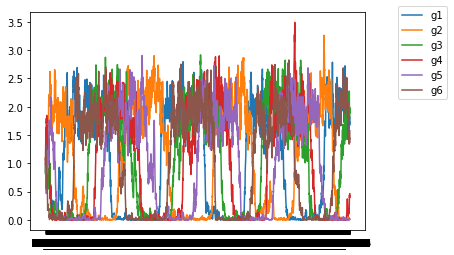

In [107]:
# total 3000 step, cycleが繰り返されている
for idx, gene in enumerate(df_normal.index):
    plt.plot(df_normal.iloc[idx,:])
plt.legend(df_normal.index, loc=(1.1,0.6))

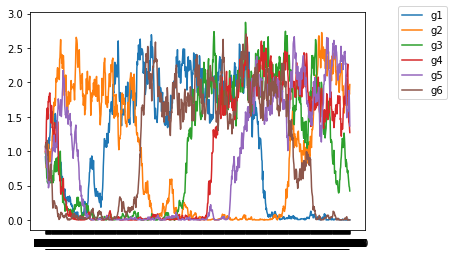

In [108]:
# 最初の900 step, 周期が見えるくらい
# blue, brown, green, red, purple, orangeの順にあがっている
for idx, gene in enumerate(df_normal.index):
    plt.plot(df_normal.iloc[idx,:900])
plt.legend(df_normal.index, loc=(1.1,0.6))

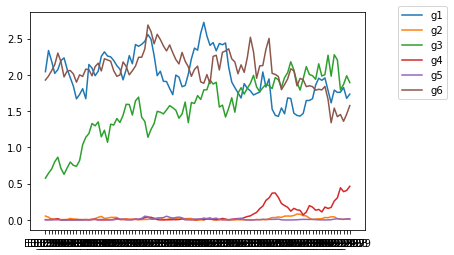

In [109]:
# 終了直前（この最終状態が次のperturbationの初期状態になっているか確認。green, brown, blue, red, purple, orangeの順。）
for idx, gene in enumerate(df_normal.index):
    plt.plot(df_normal.iloc[idx,2900:2999])
plt.legend(df_normal.index, loc=(1.1,0.6))

## Perturabation Control

In [110]:
path_ctrl = output_dir + "/" + model_definition[:-4] + "-perturbation-control" + "/simulations/" + "E0.csv"
df_ctrl = pd.read_csv(path_ctrl, index_col=0)
df_ctrl

,E0_1,E0_2,E0_3,E0_4,E0_5,E0_6,E0_7,E0_8,E0_9,E0_10,...,E0_2990,E0_2991,E0_2992,E0_2993,E0_2994,E0_2995,E0_2996,E0_2997,E0_2998,E0_2999
g1,1.655003,1.535592,1.620739,1.648660,1.541085,1.322692,1.348137,1.508546,1.753115,1.836235,...,1.845851,1.884349,1.720678,1.558391,1.735722,1.708843,1.714815,1.782151,1.637843,1.698441
g2,0.008228,0.006322,0.001949,0.001949,0.013646,0.014988,0.006615,0.002542,0.005502,0.008177,...,2.035978,2.215947,2.197643,2.299591,2.287137,2.114198,2.036618,1.832582,1.646510,1.648205
g3,1.857017,1.846534,1.744440,1.628154,1.421668,1.506921,1.420587,1.544187,1.526712,1.643681,...,0.001093,0.001559,0.009188,0.009188,0.028626,0.021522,0.021522,0.025895,0.036449,0.020898
g4,0.485309,0.610489,0.644650,0.925513,1.077102,1.169877,1.213870,1.118783,1.380313,1.418056,...,0.013370,0.029603,0.011473,0.009189,0.019340,0.015942,0.032540,0.005536,0.004564,0.005985
g5,0.023240,0.015809,0.010116,0.010116,0.000699,0.002898,0.002898,0.002898,0.002898,0.002898,...,0.002021,0.002021,0.002021,0.005428,0.013084,0.019456,0.013197,0.008961,0.018527,0.018527
g6,1.702012,1.784389,1.764639,1.731540,1.907067,1.940611,1.860660,1.793551,1.933194,1.758093,...,0.000154,0.000538,0.000538,0.000538,0.003639,0.003639,0.002387,0.002387,0.004568,0.008599


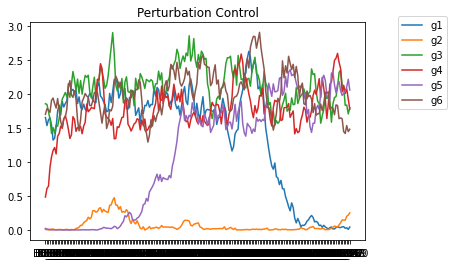

In [111]:
# 初期状態がNormal simulationの最終状態からの続きであることを確認 (green, brown, blue, red, purple, orangeの順)
for idx, gene in enumerate(df_per.index):
    plt.plot(df_ctrl.iloc[idx,:200])
plt.title("Perturbation Control")
plt.legend(df_ctrl.index, loc=(1.1,0.6))

## g1 perturbation

In [112]:
perturbed_gene = "g1"
path_per = output_dir + "/" + model_definition[:-4] + "-perturbation-transcription-" + perturbed_gene + "/simulations/" + "E0.csv"
df_per = pd.read_csv(path_per, index_col=0)
df_per

,E0_1,E0_2,E0_3,E0_4,E0_5,E0_6,E0_7,E0_8,E0_9,E0_10,...,E0_2990,E0_2991,E0_2992,E0_2993,E0_2994,E0_2995,E0_2996,E0_2997,E0_2998,E0_2999
g1,1.554970,1.350257,1.351500,1.307191,1.149377,0.906183,0.880548,0.969437,1.129141,1.163110,...,0.883316,0.910184,0.796967,0.687205,0.806307,0.788801,0.793441,0.839935,0.741516,0.783408
g2,0.008228,0.006322,0.001952,0.001952,0.013676,0.015049,0.006722,0.002739,0.005891,0.008777,...,2.036992,2.217047,2.198807,2.300940,2.288796,2.115997,2.038682,1.834792,1.649314,1.651612
g3,1.857017,1.846534,1.744440,1.628154,1.421668,1.506921,1.420587,1.544187,1.526711,1.643679,...,0.003226,0.003827,0.015611,0.015611,0.040567,0.031454,0.031454,0.036187,0.048100,0.029609
g4,0.485309,0.610489,0.644650,0.925513,1.077102,1.169877,1.213870,1.118783,1.380313,1.418056,...,0.013969,0.030532,0.012073,0.009699,0.020102,0.016600,0.033504,0.006055,0.005011,0.006478
g5,0.023240,0.015809,0.010116,0.010116,0.000699,0.002898,0.002898,0.002898,0.002898,0.002898,...,0.002254,0.002254,0.002254,0.005851,0.013792,0.020318,0.013890,0.009512,0.019343,0.000028
g6,1.702012,1.784389,1.764636,1.731530,1.907041,1.940556,1.860544,1.793310,1.932842,1.757620,...,0.000010,0.000077,0.000077,0.000077,0.001093,0.001093,0.000238,0.000238,0.000684,0.001998


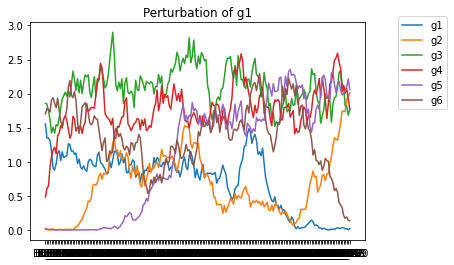

In [113]:
# blue(g1)の発現が下がり、他も影響を受けているのがわかる
# +の制御を受けているg6(brown)が下がり、-の制御を受けているg2(orange)が上がっている。
for idx, gene in enumerate(df_per.index):
    plt.plot(df_per.iloc[idx,:200])
plt.title("Perturbation of {}".format(perturbed_gene))
plt.legend(df_per.index, loc=(1.1,0.6))

## g2 perturbation

In [114]:
perturbed_gene = "g2"
path_per = output_dir + "/" + model_definition[:-4] + "-perturbation-transcription-" + perturbed_gene + "/simulations/" + "E0.csv"
df_per = pd.read_csv(path_per, index_col=0)
df_per

,E0_1,E0_2,E0_3,E0_4,E0_5,E0_6,E0_7,E0_8,E0_9,E0_10,...,E0_2990,E0_2991,E0_2992,E0_2993,E0_2994,E0_2995,E0_2996,E0_2997,E0_2998,E0_2999
g1,1.655003,1.535592,1.620739,1.648660,1.541085,1.322692,1.348137,1.508546,1.753115,1.836235,...,1.924424,1.957808,1.784524,1.614049,1.789804,1.758215,1.761154,1.825994,1.676390,1.734386
g2,0.007921,0.005791,0.001341,0.001341,0.010899,0.011981,0.004282,0.000702,0.002296,0.003999,...,0.020444,0.037075,0.034092,0.046126,0.044273,0.020103,0.011952,0.011952,0.011952,0.008227
g3,1.857017,1.846534,1.744440,1.628155,1.421670,1.506925,1.420597,1.544210,1.526749,1.643748,...,2.071661,2.085033,2.358907,2.061245,2.358826,2.283720,1.858396,1.932520,2.052361,1.957437
g4,0.485309,0.610489,0.644650,0.925513,1.077102,1.169877,1.213870,1.118783,1.380313,1.418056,...,1.961273,2.172879,2.021295,1.999445,2.159723,2.125883,2.321425,2.086187,2.065764,2.096474
g5,0.023240,0.015809,0.010116,0.010116,0.000699,0.002898,0.002898,0.002898,0.002898,0.002898,...,1.524301,1.453921,1.392728,1.537375,1.712802,1.822677,1.791022,1.764529,1.920480,1.746136
g6,1.702012,1.784389,1.764639,1.731540,1.907067,1.940611,1.860660,1.793551,1.933194,1.758093,...,1.793591,1.841561,1.662051,1.341596,1.542551,1.424322,1.454464,1.361230,1.460079,1.577490


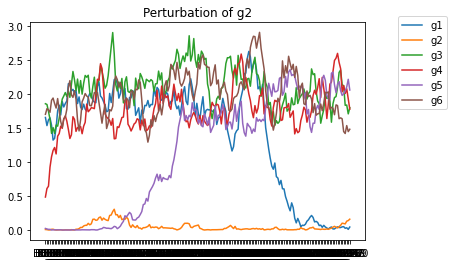

In [115]:
# orange(g2)の発現が下がっているが、元々小さかったので他のgeneはまだあまり影響をうけていない (controlは上参照)
for idx, gene in enumerate(df_per.index):
    plt.plot(df_per.iloc[idx,:200])
plt.title("Perturbation of {}".format(perturbed_gene))
plt.legend(df_per.index, loc=(1.1,0.6))

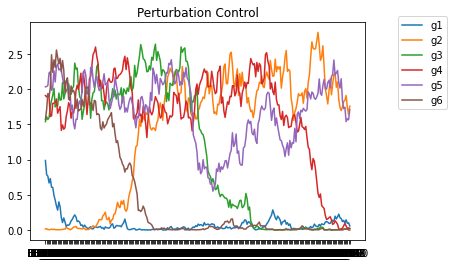

In [116]:
# Controlの150~400 step
for idx, gene in enumerate(df_per.index):
    plt.plot(df_ctrl.iloc[idx,150:400])
plt.title("Perturbation Control")
plt.legend(df_ctrl.index, loc=(1.1,0.6))

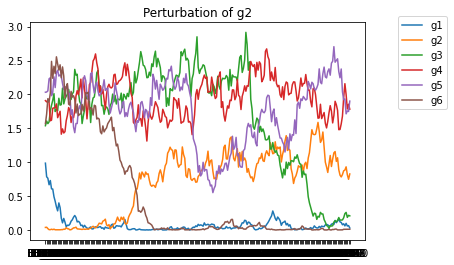

In [117]:
# 200 stepくらいで違いが見えてくる。
# g2が1.0までしか上がらなくなり、g2から-の制御を受けているg3が下がるのが遅くなる。それに続きg4が下がるのが遅くなる。
for idx, gene in enumerate(df_per.index):
    plt.plot(df_per.iloc[idx,150:400])
plt.title("Perturbation of {}".format(perturbed_gene))
plt.legend(df_per.index, loc=(1.1,0.6))